# Flutter Analysis of a Goland Wing using the SHARPy Linear Solver

This is an example using SHARPy to find the flutter speed of a Goland wing by:

* Calculating aerodynamic forces and deflections using a nonlinear solver

* Linearising about this reference condition

* Creating a reduced order model of the linearised aerodynamics

* Evaluate the stability of the linearised aeroelastic system at different velocities

#### References

Maraniello, S., & Palacios, R. (2019). State-Space Realizations and Internal Balancing in Potential-Flow Aerodynamics with Arbitrary Kinematics. AIAA Journal, 57(6), 1–14. https://doi.org/10.2514/1.J058153



## Required Packages

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
os.chdir('/home/ansley/sharpy/')
import sys
import sharpy_control.cases.templates.flying_wings as wings  # See this package for the Goland wing structural and aerodynamic definition
import sharpy_control.sharpy_main  # used to run SHARPy from Jupyter
import sharpy_control.utils.generate_cases as gc
import sharpy_control.utils.h5utils as h5utils
import scipy.optimize as opt
from sharpy_control.utils.constants import deg2rad # Constant to conver degrees to radians
import scipy.signal as sig
from pazy_wing_model import PazyWing

## Problem Set-up

### Velocity

The UVLM is assembled in normalised time at a velocity of $1 m/s$. The only matrices that need updating then with free stream velocity are the structural matrices, which is significantly cheaper to do than to update the UVLM.

In [3]:
pazy = False

u_inf = 1
u_true = 1  # true velocity, for scaling of linearised model
if pazy:
    alpha_deg = 0
else:
    alpha_deg = 2.
rho = 1.02
num_modes = 8

### Discretisation

Note: To achieve convergence of the flutter results with the ones found in the literature, a significant discretisation may be required. If you are running this notebook for the first time, set `M = 4` initially to verify that your system can perform!

In [5]:
M = 16
N = 32
# M = 4
# N = 8
M_star_fact = 10

### ROM

A moment-matching (Krylov subspace) model order reduction technique is employed. This ROM method offers the ability to interpolate the transfer functions at a desired point in the complex plane. See the ROM documentation pages for more info.

Note: this ROM method matches the transfer function but does not guarantee stability. Therefore the resulting system may be unstable. These unstable modes may appear far in the right hand plane but will not affect the flutter speed calculations.

In [6]:
if not pazy: c_ref = 1.8288 # Goland wing reference chord. Used for frequency normalisation
else: c_ref = 0.1  # Pazy wing reference chord
rom_settings = dict()
rom_settings['algorithm'] = 'mimo_rational_arnoldi'  # reduction algorithm
rom_settings['r'] = 6  # Krylov subspace order
frequency_continuous_k = np.array([0.])  # Interpolation point in the complex plane with reduced frequency units
frequency_continuous_w = 2 * u_inf * frequency_continuous_k / c_ref
rom_settings['frequency'] = frequency_continuous_w

### Case Admin

In [7]:
if not pazy:
    case_name = 'goland_cs'
else:
    case_name = 'pazy_cs'
case_nlin_info = 'M%dN%dMs%d_nmodes%d' % (M, N, M_star_fact, num_modes)
case_rom_info = 'rom_MIMORA_r%d_sig%04d_%04dj' % (rom_settings['r'], frequency_continuous_k[-1].real * 100,
                                                  frequency_continuous_k[-1].imag * 100)

case_name += case_nlin_info + case_rom_info

route_test_dir = os.path.abspath('')

print('The case to run will be: %s' % case_name)
print('Case files will be saved in ./cases/%s' %case_name)
print('Output files will be saved in ./output/%s/' %case_name)

The case to run will be: goland_csM16N32Ms10_nmodes8rom_MIMORA_r6_sig0000_0000j
Case files will be saved in ./cases/goland_csM16N32Ms10_nmodes8rom_MIMORA_r6_sig0000_0000j
Output files will be saved in ./output/goland_csM16N32Ms10_nmodes8rom_MIMORA_r6_sig0000_0000j/


## Simulation Set-Up

### Goland Wing

`ws` is an instance of a Goland wing with a control surface. Reference the template file `cases.templates.flying_wings.GolandControlSurface` for more info on the geometrical, structural and aerodynamic definition of the Goland wing here used.

In [8]:
# Compute the number of time steps needed based on the previous parameters
# Time discretization
end_time = 2  # End time of the simulation
dt = c_ref/N/u_inf  # Always keep one timestep per panel
time_steps = 1  # static sim
print('dt:', dt)
print('tsteps:', time_steps)
flap_frac = 0.25
controlled = False  # should not matter here
n_surfaces = 2

if not pazy:
    ws = wings.GolandControlSurface(M=M,
                                    N=N,
                                    Mstar_fact=M_star_fact,
                                    u_inf=u_inf,
                                    alpha=alpha_deg,
                                    cs_deflection=[0, 0],
                                    rho=rho,
                                    sweep=0,
                                    physical_time=end_time,
                                    n_surfaces=n_surfaces,
                                    route=route_test_dir + '/cases',
                                    case_name=case_name,
                                    pct_flap=flap_frac,  # fraction of span of flap
                                    )
else:
    ws = wings.PazyControlSurface(M=M,
                                    N=N,
                                    Mstar_fact=M_star_fact,
                                    u_inf=u_inf,
                                    alpha=alpha_deg,
                                    cs_deflection=[0, 0],
                                    rho=rho,
                                    physical_time=end_time,
                                    n_surfaces=n_surfaces,
                                    route=route_test_dir + '/cases',
                                    case_name=case_name,
                                    pct_flap=flap_frac,  # fraction of span of flap
                                    )

# Default values initialisation
ws.clean_test_files()
ws.update_derived_params()
ws.set_default_config_dict()

# UPDATE ALL CUSTOM PARAMS BELOW
# ws.dt = dt
# ws.n_tstep = time_steps
ws.control_surface_chord = ws.M // 4 * np.ones(ws.n_control_surfaces, dtype=int)  # quarter chord (default is half chord)
if controlled:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 2  # 0=static, 1=dynamic, 2=controlled
else:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 0  # UPDATE ALL CUSTOM PARAMS ABOVE

ws.generate_aero_file()
ws.generate_fem_file()

# ws.config['DynamicCoupled']

dt: 0.05715
tsteps: 1


### Simulation Settings

The settings for each of the solvers are now set. For a detailed description on them please reference their respective documentation pages

#### SHARPy Settings

The most important setting is the `flow` list. It tells SHARPy which solvers to run and in which order.

In [9]:
ws.config['SHARPy'] = {
    'flow':
        ['BeamLoader',
         'AerogridLoader',
         'StaticCoupled',
        #  'StaticTrim',
         'AerogridPlot',
         'BeamPlot',
        #  'DynamicCoupled',
         'Modal',
         'LinearAssembler',
         'AsymptoticStability',
         ],
    'case': ws.case_name, 'route': ws.route,
    'write_screen': 'on', 'write_log': 'on',
    'log_folder': route_test_dir + '/output/',
    'log_file': ws.case_name + '.log'}
ws.config['SHARPy']
try:
    os.mkdir(ws.config['SHARPy']['log_folder'])
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.config['SHARPy']['case'])
except FileExistsError:
    pass

#### Beam Loader and Aerogrid Loader Settings

In [10]:
ws.config['BeamLoader'] = {
    'unsteady': 'off',
    'orientation': ws.quat}

csdict = {'deflection_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt',
          'dt': ws.dt,
         }
ws.config['AerogridLoader'] = {
    'unsteady': 'off',
    'aligned_grid': 'on',
    'mstar': ws.Mstar_fact * ws.M,
    'freestream_dir': ws.u_inf_direction,
    'wake_shape_generator': 'StraightWake',
    'wake_shape_generator_input': {'u_inf': ws.u_inf,
                                    'u_inf_direction': ws.u_inf_direction,
                                    'dt': ws.dt}}


#### Static Coupled Solver

In [11]:
num_cores = 8
ws.config['StaticCoupled'] = {
    'print_info': 'on',
    'max_iter': 200,
    'n_load_steps': 1,
    'tolerance': 1e-10,
    'relaxation_factor': 0.,
    'aero_solver': 'StaticUvlm',
    'aero_solver_settings': {
        'rho': ws.rho,
        'print_info': 'off',
        'horseshoe': 'off',
        'num_cores': num_cores,
        'n_rollup': 0,
        'rollup_dt': ws.dt,
        'rollup_aic_refresh': 1,
        'rollup_tolerance': 1e-4,
        'velocity_field_generator': 'SteadyVelocityField',
        'velocity_field_input': {
            'u_inf': ws.u_inf,
            'u_inf_direction': ws.u_inf_direction}},
    'structural_solver': 'NonLinearStatic',
    'structural_solver_settings': {'print_info': 'off',
                                   'max_iterations': 150,
                                   'num_load_steps': 4,
                                   'delta_curved': 1e-1,
                                   'min_delta': 1e-10,
                                   'gravity_on': 'on',
                                   'gravity': 9.81},
}
# ws.config['StaticTrim'] = {
#     'solver': 'StaticCoupled',
#     'solver_settings': ws.config['StaticCoupled'],
#     'thrust_nodes': ws.thrust_nodes,
#     'initial_alpha': ws.alpha,
#     'initial_deflection': ws.cs_deflection,
#     'initial_thrust': ws.thrust,
#     'max_iter': 200,
#     'fz_tolerance': 1e-2,
#     'fx_tolerance': 1e-2,
#     'm_tolerance': 1e-2,
# }

#### AerogridPlot and BeamPlot Settings

In [12]:
ws.config['AerogridPlot'] = {'include_rbm': 'off',
                             'include_applied_forces': 'on',
                             'minus_m_star': 0}

ws.config['BeamPlot'] = {'include_rbm': 'off',
                         'include_applied_forces': 'on'}

#### Modal Solver and Linear System Assembly Settings

In [13]:
ws.config['Modal'] = {'NumLambda': 20,
                      'rigid_body_modes': 'off',
                      'print_matrices': 'on',
                      # 'keep_linear_matrices': 'on',
                    #   'write_dat': 'off',
                      'rigid_modes_cg': 'off',
                      'continuous_eigenvalues': 'off',
                      'dt': 0,
                      'plot_eigenvalues': False,
                      'max_rotation_deg': 15.,
                      'max_displacement': 0.15,
                      'write_modes_vtk': True,
                      'use_undamped_modes': True}

ws.config['LinearAssembler'] = {'linear_system': 'LinearAeroelastic',
                                'linear_system_settings': {
                                    'beam_settings': {'modal_projection': 'on',
                                                      'inout_coords': 'modes',
                                                      'discrete_time': 'on',
                                                      'newmark_damp': 0.5e-4,
                                                      'discr_method': 'newmark',
                                                      'dt': ws.dt,
                                                      'proj_modes': 'undamped',
                                                      'use_euler': 'off',
                                                      'num_modes': num_modes,
                                                      'print_info': 'on',
                                                      'gravity': 'on',
                                                      'remove_sym_modes': 'on',
                                                      'remove_dofs': []},
                                    'aero_settings': {'dt': ws.dt,
                                                      'ScalingDict': {'length': 0.5 * ws.c_ref,
                                                                      'speed': u_inf,
                                                                      'density': ws.rho},
                                                      'integr_order': 2,
                                                      'density': ws.rho,
                                                      'remove_predictor': 'on',
                                                      'use_sparse': 'on',
                                                      'remove_inputs': ['u_gust'],
                                                      'rom_method': ['Krylov'],
                                                      'rom_method_settings': {'Krylov': rom_settings}},
                                    }}

#### Asymptotic Stability Analysis Settings

In [14]:
vmin = 10
vmax = 180 if not pazy else 120
vnum = (vmax - vmin) * 100 + 1
ws.config['AsymptoticStability'] = {'print_info': True,
                                    'velocity_analysis': [vmin, vmax, vnum],
                                    'modes_to_plot': []}
print(vmin, vmax, vnum)

10 180 17001


### Write solver settings config file

In [15]:
ws.config.write()
nocontrol_output_dir = ws.config['SHARPy']['log_folder'] + ws.case_name + '/'
print(ws.route + ws.case_name)

/home/ansley/sharpy/cases/goland_csM16N32Ms10_nmodes8rom_MIMORA_r6_sig0000_0000j


## Run SHARPy (Static, VF)

In [16]:
# if vnum < 1000:
#     vstr = '0' + str(vnum)
file_name = './output/%s/stability/velocity_analysis_min{:03}0_max{:03}0_nvel{:04}.dat'.format(vmin, vmax, vnum) % case_name

# try:  # skip sim if file exists
#     velocity_analysis = np.loadtxt(file_name)
# except:  # rum sim if no file exists
#     sharpy_output = sharpy.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])

sharpy_output = sharpy_control.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ansley/sharpy
SHARPy being run is in /home/ansley/sharpy
The branch being run is develop
The version and commit hash are: 2.0-309-g362cd337-362cd337
SHARPy outp

/home/ansley/miniconda3/envs/sharpy/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	state-space model produced in form:
			h_{n+1} = A h_{n} + B u_{n}
			with:
	x_n = h_n + Bp u_n
			...done in 9.46 sec
Scaling UVLM system with reference time 0.914400s
Non-dimensional time step set (0.125000)
System scaled in 19.848642s
Generating an instance of LinearBeam
Variable remove_rigid_states has no assigned value in the settings file.
    will default to the value: False
Warning, projecting system with damping onto undamped modes


/home/ansley/sharpy/sharpy/linear/src/lingebm.py:313: UserWarning: Euler parametrisation not implemented - Either rigid body modes are not being used or this method has already been called.
  warnings.warn('Euler parametrisation not implemented - Either rigid body modes are not being used or this '



Linearising gravity terms...
	M = 0.78 kg
	X_CG A -> -0.42 0.27 0.00
Node  1 	-> B -0.000 -0.116 0.000
			-> A 0.116 0.381 -0.000
			-> G 0.116 0.381 -0.004
	Node mass:
		Matrix: 14.5125
Node  2 	-> B -0.000 -0.116 0.000
			-> A 0.116 0.762 -0.000
			-> G 0.116 0.762 -0.004
	Node mass:
		Matrix: 7.2563
Node  3 	-> B -0.000 -0.116 0.000
			-> A 0.116 1.143 -0.000
			-> G 0.116 1.143 -0.004
	Node mass:
		Matrix: 14.5125
Node  4 	-> B -0.000 -0.116 0.000
			-> A 0.116 1.524 -0.001
			-> G 0.116 1.524 -0.005
	Node mass:
		Matrix: 7.2563
Node  5 	-> B -0.000 -0.116 0.000
			-> A 0.116 1.905 -0.001
			-> G 0.116 1.905 -0.005
	Node mass:
		Matrix: 14.5125
Node  6 	-> B -0.000 -0.116 0.000
			-> A 0.116 2.286 -0.001
			-> G 0.116 2.286 -0.005
	Node mass:
		Matrix: 7.2563
Node  7 	-> B -0.000 -0.116 0.000
			-> A 0.116 2.667 -0.002
			-> G 0.116 2.667 -0.006
	Node mass:
		Matrix: 14.5125
Node  8 	-> B -0.000 -0.116 0.000
			-> A 0.116 3.048 -0.002
			-> G 0.116 3.048 -0.006
	Node mass:
		Matri

/home/ansley/sharpy/sharpy/rom/krylov.py:242: UserWarning: Reduced Order Model Unstable
  warn.warn('Reduced Order Model Unstable')


LTI	u: 10.73 m/2	max. CT eig. real: 24.923275	
	N unstab.: 001
	Unstable aeroelastic natural frequency CT(rad/s):	24.92
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 10.74 m/2	max. CT eig. real: 24.946502	
	N unstab.: 001
	Unstable aeroelastic natural frequency CT(rad/s):	24.95
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 10.75 m/2	max. CT eig. real: 24.969730	
	N unstab.: 001
	Unstable aeroelastic natural frequency CT(rad/s):	24.97
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 10.76 m/2	max. CT eig. real: 24.992958	
	N unstab.: 001
	Unstable aeroelastic natural frequency CT(rad/s):	24.99
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 10.77 m/2	max. CT eig. real: 25.016185	
	N unstab.: 001
	Unstable aeroelastic natural frequency CT(rad/s):	25.02
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 10.

In [17]:
# print(dir(sharpy_output.aero.timestep_info[0]))
# print((sharpy_output.aero.timestep_info[0].n_surf))
# print(dir(ws))
# print(ws.tip_rod)
# print(dir(sharpy_output.structure.timestep_info[0]))
print((sharpy_output.structure.timestep_info[0].glob_pos().shape))
print((sharpy_output.structure.timestep_info[0].psi[:, 1].shape))
print((sharpy_output.structure.timestep_info[0].psi))

(33, 3)
(16, 3)
[[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
  [-1.28794232e-04  5.72267352e-04  1.57079613e+00]
  [-7.23740953e-05  3.01490806e-04  1.57079623e+00]]

 [[-1.28794232e-04  5.72267352e-04  1.57079613e+00]
  [-2.00010419e-04  1.02788554e-03  1.57079592e+00]
  [-1.70820746e-04  8.13880745e-04  1.57079602e+00]]

 [[-2.00010419e-04  1.02788554e-03  1.57079592e+00]
  [-2.26112379e-04  1.37928124e-03  1.57079571e+00]
  [-2.17922384e-04  1.21583388e-03  1.57079581e+00]]

 [[-2.26112379e-04  1.37928124e-03  1.57079571e+00]
  [-2.19556179e-04  1.63888786e-03  1.57079554e+00]
  [-2.26138647e-04  1.51978053e-03  1.57079562e+00]]

 [[-2.19556179e-04  1.63888786e-03  1.57079554e+00]
  [-1.92792332e-04  1.81914365e-03  1.57079540e+00]
  [-2.07922571e-04  1.73815672e-03  1.57079546e+00]]

 [[-1.92792332e-04  1.81914365e-03  1.57079540e+00]
  [-1.58267789e-04  1.93249007e-03  1.57079530e+00]
  [-1.75722653e-04  1.88340250e-03  1.57079534e+00]]

 [[-1.58267789e-04  1.93249007e-03  

## Finding V_F

### Nonlinear equilibrium

The nonlinear equilibrium condition can be visualised and analysed by opening, with Paraview, the files in the `/output/<case_name>/aero` and `/output/<case_name>/beam` folders to see the deflection and aerodynamic forces acting

### Stability 

The stability of the Goland wing is now analysed under changing free stream velocity. The aeroelastic system is projected onto 2 structural modes (1st bending and 1st torsion). The two modes are seen quite separated at 100 m/s. As speed is increased, the damping of the torsion mode decreases until it crosses the imaginary axis onto the right hand plane and flutter begins. This flutter mode is a bending-torsion mode, as seen from the natural frequency plot where the frequencies of each coalesce into this mode.

In [18]:
velocity_analysis = np.loadtxt(file_name)
u = velocity_analysis[:, 0]
eigs_r = velocity_analysis[:, 1]
eigs_i = velocity_analysis[:, 2]

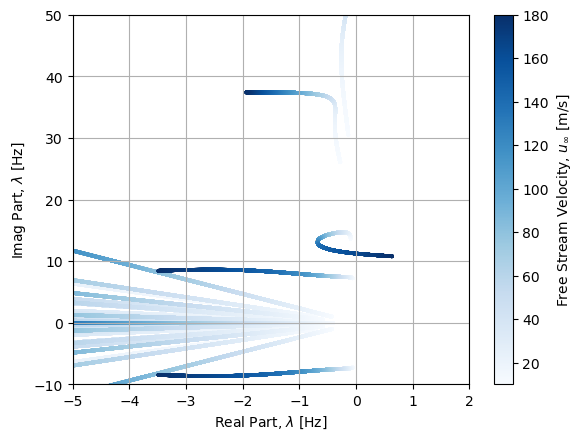

In [19]:
fig = plt.figure()
plt.scatter(eigs_r/(2*np.pi), eigs_i/(2*np.pi), c=u, cmap='Blues', s=2.5)
cbar = plt.colorbar()
cbar.set_label('Free Stream Velocity, $u_\infty$ [m/s]')

plt.grid()
plt.xlim(-5, 2)
plt.ylim(-10, 50)
plt.xlabel('Real Part, $\lambda$ [Hz]')
plt.ylabel('Imag Part, $\lambda$ [Hz]');

[163.74 163.74 163.75 163.75 163.76 163.76 163.77 163.77 163.78 163.78]
V_F: 163.74
163.74 [ 1.00000000e+00 -7.75488011e-05 -7.75488011e-05 -2.81412579e-01 -2.81412579e-01 -4.65908437e-02 -4.65908437e-02
 -1.00000000e+00 -6.82499828e-03 -6.82499828e-03 -3.93162904e-01 -3.93162904e-01 -6.99152979e-01 -6.99152979e-01
 -9.68309440e-01 -9.68309440e-01 -5.89041080e-01 -5.89041080e-01 -8.36295055e-01 -8.36295055e-01 -9.97845734e-01
 -9.97845734e-01 -7.91642431e-01 -7.91642431e-01 -9.88131425e-01 -9.88131425e-01 -8.42643263e-01 -8.42643263e-01
 -9.54969999e-01 -9.54969999e-01 -9.30839363e-01 -9.30839363e-01 -9.92670585e-01 -9.92670585e-01 -9.63152312e-01
 -9.63152312e-01 -6.17383646e-01 -6.17383646e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -8.79250829e-01 -8.79250829e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -6.00624951e-01 -5.92514784e-01 -5.53189446e-01 -5.23274867e-01]


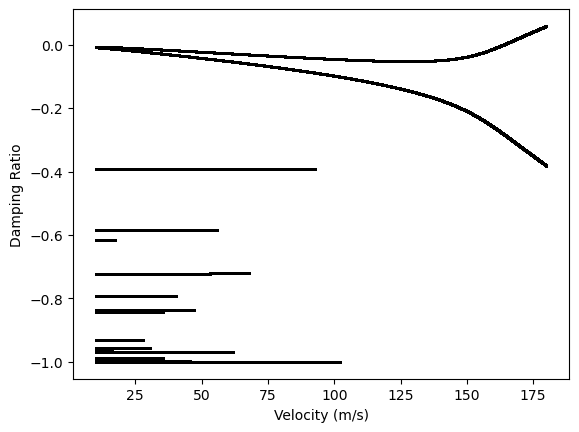

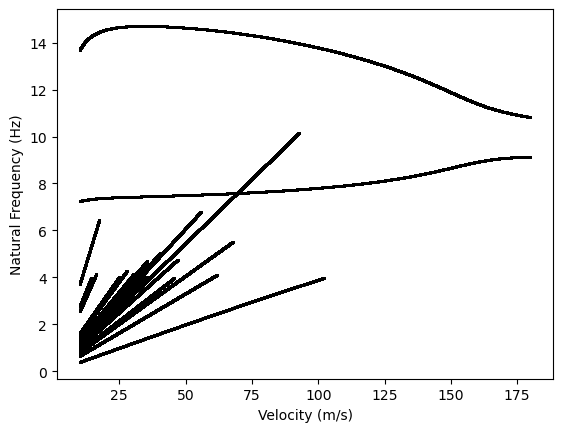

In [21]:
from re import U


natural_frequency = np.sqrt(eigs_r ** 2 + eigs_i ** 2)
damping_ratio = eigs_r / natural_frequency

if pazy: cond = (eigs_r/(2*np.pi)>-5) * ((eigs_r/(2*np.pi))<5) * (natural_frequency/(2*np.pi) < 50) * (natural_frequency/(2*np.pi) > 10) # filter unwanted eigenvalues for this plot (mostly aero modes)
else: cond = (eigs_r>-25) * (eigs_r<10) * (natural_frequency<100)

v = u[cond][np.where(np.isclose(damping_ratio[cond], 0.0, atol=1e-4))]
# v = u[np.where(np.isclose(damping_ratio, 0.0, atol=1e-4))]
print(v)
vf = min(v)
print('V_F:', vf)
# print(abs(damping_ratio).min(), np.argmin(abs(damping_ratio)), damping_ratio.shape, u.shape)
print(vf, damping_ratio[np.where(u==vf)])

plt.figure(dpi=100)
plt.scatter(u[cond], damping_ratio[cond], color='k', marker='o', s=1)
plt.ylabel('Damping Ratio')
plt.xlabel('Velocity (m/s)')
plt.show()
plt.figure(dpi=100)
plt.scatter(u[cond], natural_frequency[cond]/(2*np.pi), color='k', marker='o', s=1)
plt.ylabel('Natural Frequency (Hz)')
plt.xlabel('Velocity (m/s)')
plt.show()


# Run dynamic analysis with V_F
## First run without controller (control setup)

In [20]:
# Compute the number of time steps needed based on the previous parameters
# Time discretization
u_inf = 1
u_true = vf
end_time = 1.5
dt = c_ref/N/u_true  # Always keep one timestep per panel
time_steps = int(end_time/dt)


aero = 'StepUvlm'
velocity_field = 'SteadyVelocityField'

if aero == 'StepLinearUVLM': u = u_inf
elif aero == 'StepUvlm': u = u_true
controlled = False  # this is a control setup, without controller (static control surface)

if not pazy:
    ws = wings.GolandControlSurface(M=M,
                                    N=N,
                                    Mstar_fact=M_star_fact,
                                    u_inf=u,
                                    alpha=alpha_deg,
                                    cs_deflection=[0, 0],
                                    rho=rho,
                                    sweep=0,
                                    physical_time=end_time,
                                    n_surfaces=n_surfaces,
                                    route=route_test_dir + '/cases',
                                    case_name=case_name,
                                    pct_flap=flap_frac,  # fraction of span of flap
                                    )
else:
    ws = wings.PazyControlSurface(M=M,
                                    N=N,
                                    Mstar_fact=M_star_fact,
                                    u_inf=u,
                                    alpha=alpha_deg,
                                    cs_deflection=[0, 0],
                                    rho=rho,
                                    physical_time=end_time,
                                    n_surfaces=n_surfaces,
                                    route=route_test_dir + '/cases',
                                    case_name=case_name,
                                    pct_flap=flap_frac,  # fraction of span of flap
                                    )

# Default values initialisation
ws.clean_test_files()
ws.update_derived_params()
ws.set_default_config_dict()

# UPDATE ALL CUSTOM PARAMS BELOW
ws.dt = dt
ws.n_tstep = time_steps
ws.control_surface_chord = ws.M // 4 * np.ones(ws.n_control_surfaces, dtype=int)  # quarter chord (default is half chord)
if controlled: ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 2  # 0=static, 1=dynamic, 2=controlled
else: ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 0
# UPDATE ALL CUSTOM PARAMS ABOVE

ws.generate_aero_file()
ws.generate_fem_file()


ws.config['SHARPy'] = {
    'flow':
        ['BeamLoader',
         'AerogridLoader',
         'StaticCoupled',
         'AerogridPlot',
         'BeamPlot',
         'DynamicCoupled',
         ],
    'case': ws.case_name, 'route': ws.route,
    'write_screen': 'on', 'write_log': 'on',
    'log_folder': route_test_dir + '/output/',
    'log_file': ws.case_name + '.log'}
ws.config['SHARPy']
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.config['SHARPy']['case'])
except FileExistsError:
    pass

ws.config['BeamLoader'] = {
    'unsteady': True,
    'orientation': ws.quat}

# csdict = {'deflection_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt',
#           'dt': ws.dt,
#          }
ws.config['AerogridLoader'] = {'unsteady': True,
                                'aligned_grid': 'on',
                                'mstar': ws.Mstar_fact * ws.M,
                                'freestream_dir': ws.u_inf_direction,
                                'wake_shape_generator': 'StraightWake',
                                'wake_shape_generator_input': {'u_inf': ws.u_inf,
                                                                'u_inf_direction': ws.u_inf_direction,
                                                                'dt': ws.dt},
                               #'control_surface_deflection': ['DynamicControlSurface', 'DynamicControlSurface'],
                               #'control_surface_deflection_generator_settings': {'0': csdict,
                               #                                                  '1': csdict,
                               #                                                  }
                            }


ws.config['StaticCoupled'] = {
    'print_info': 'on',
    'max_iter': 200,
    'n_load_steps': 1,
    'tolerance': 1e-10,
    'relaxation_factor': 0.,
    'aero_solver': 'StaticUvlm',
    'aero_solver_settings': {
        'rho': ws.rho,
        'print_info': 'off',
        'horseshoe': 'off',
        'num_cores': num_cores,
        'n_rollup': 0,
        'rollup_dt': ws.dt,
        'rollup_aic_refresh': 1,
        'rollup_tolerance': 1e-4,
        'velocity_field_generator': 'SteadyVelocityField',
        'velocity_field_input': {
            'u_inf': ws.u_inf,
            'u_inf_direction': ws.u_inf_direction}},
    'structural_solver': 'NonLinearStatic',
    'structural_solver_settings': {'print_info': 'off',
                                   'max_iterations': 150,
                                   'num_load_steps': 4,
                                   'delta_curved': 1e-1,
                                   'min_delta': 1e-10,
                                   'gravity_on': 'on',
                                   'gravity': 9.81},
}

fsi_steps = 2000
fsi_tol = 1e-8
relax_steps = 500
relax_fact = 0
ws.config['DynamicCoupled']['print_info'] = True
ws.config['DynamicCoupled']['fsi_substeps'] = fsi_steps
ws.config['DynamicCoupled']['fsi_tolerance'] = fsi_tol
ws.config['DynamicCoupled']['dynamic_relaxation'] = False
ws.config['DynamicCoupled']['relaxation_steps'] = relax_steps
ws.config['DynamicCoupled']['relaxation_factor'] = relax_fact

ws.config['DynamicCoupled']['structural_solver_settings']['gravity_on'] = False
ws.config['DynamicCoupled']['structural_solver_settings']['dt'] = dt
ws.config['DynamicCoupled']['structural_solver_settings']['num_steps'] = time_steps

ws.config['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
'''
ws.config['DynamicCoupled']['postprocessors'] = {"BeamPlot": {"include_rbm": "on", "include_applied_forces": "on"},
                                                 "AerogridPlot": {"u_inf": ws.u_inf,
                                                                "include_rbm": "on",
                                                                "include_applied_forces": "on",
                                                                "minus_m_star": 0,}
                                                }'''

ws.config['DynamicCoupled']['aero_solver'] = aero
if aero == 'StepLinearUVLM':
    intg_order = 2
    ws.config['DynamicCoupled']['aero_solver_settings'] = {}
    ws.config['DynamicCoupled']['aero_solver_settings']['integr_order'] = intg_order
    ws.config['DynamicCoupled']['aero_solver_settings']['density'] = ws.rho
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}
    ws.config['DynamicCoupled']['aero_solver_settings']['ScalingDict'] = {'speed': u_true, 'length': c_ref, 'density': ws.rho}
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
elif aero == 'StepUvlm':
    conv_scheme = 2  # 0 (fixed wake), 2 (with bg flow), or 3 (free)
    ws.config['DynamicCoupled']['aero_solver_settings']['num_cores'] = num_cores
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
    ws.config['DynamicCoupled']['aero_solver_settings']['n_time_steps'] = time_steps
    ws.config['DynamicCoupled']['aero_solver_settings']['convection_scheme'] = 2
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}


# print(ws.config['DynamicCoupled']['aero_solver_settings'])


ws.config['DynamicCoupled']['dt'] = dt
ws.config['DynamicCoupled']['n_time_steps'] = time_steps
ws.config['DynamicCoupled']['print_info'] = True
ws.config['DynamicCoupled']['fsi_substeps'] = fsi_steps
ws.config['DynamicCoupled']['fsi_tolerance'] = fsi_tol
ws.config['DynamicCoupled']['dynamic_relaxation'] = False
ws.config['DynamicCoupled']['relaxation_steps'] = relax_steps
ws.config['DynamicCoupled']['relaxation_factor'] = relax_fact
# ws.config['DynamicCoupled']['final_relaxation_factor'] = 0.5

ws.config['DynamicCoupled']['structural_solver_settings']['gravity_on'] = False
ws.config['DynamicCoupled']['structural_solver_settings']['dt'] = dt
ws.config['DynamicCoupled']['structural_solver_settings']['num_steps'] = time_steps

ws.config['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
'''
ws.config['DynamicCoupled']['postprocessors'] = {"BeamPlot": {"include_rbm": "on", "include_applied_forces": "on"},
                                                 "AerogridPlot": {"u_inf": ws.u_inf,
                                                                "include_rbm": "on",
                                                                "include_applied_forces": "on",
                                                                "minus_m_star": 0,}
                                                }'''

ws.config['DynamicCoupled']['aero_solver'] = aero
if aero == 'StepLinearUVLM':
    ws.config['DynamicCoupled']['aero_solver_settings'] = {}
    ws.config['DynamicCoupled']['aero_solver_settings']['integr_order'] = intg_order
    ws.config['DynamicCoupled']['aero_solver_settings']['density'] = ws.rho
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}
    ws.config['DynamicCoupled']['aero_solver_settings']['ScalingDict'] = {'speed': u_true, 'length': c_ref, 'density': ws.rho}
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
elif aero == 'StepUvlm':
    ws.config['DynamicCoupled']['aero_solver_settings']['num_cores'] = num_cores
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
    ws.config['DynamicCoupled']['aero_solver_settings']['n_time_steps'] = time_steps
    ws.config['DynamicCoupled']['aero_solver_settings']['convection_scheme'] = conv_scheme
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}

# CONTROLLER IMPLEMENTATION
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller')
except FileExistsError:
    pass
x = np.zeros([time_steps, 1])
np.savetxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt', x, delimiter=',')


# for k, v in ws.config['DynamicCoupled'].items():
#    print(k, v)
# print('\nWing Properties:\n', vars(ws))

print('dt', dt, ws.dt)
print('tsteps', time_steps, ws.n_tstep)

ws.config.write()
print(ws.route + ws.case_name)

dt 0.00013739283358979996 0.00013739283358979996
tsteps 10917 10917
/home/ansley/sharpy/cases/pazy_csM4N8Ms10_nmodes8rom_MIMORA_r12_sig0000_0000j


In [21]:
# %%capture capt
# try:  # skip simulation if nocontrol sim has been run previously
#     filename = nocontrol_output_dir + 'tip_output.txt'
#     print(filename)
#     a = np.loadtxt(filename, delimiter=',')
#     time = a[:, 0]
#     tip_pos_nocontrol = a[:, 1]
#     tip_rot_nocontrol = a[:, 2]
#     aileron = a[:, 3]
# except:  # run sim if output file is not found
sharpy_output_nocontrol = sharpy_control.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])
time = np.linspace(0, dt*time_steps, time_steps)
tip_pos_nocontrol = np.zeros((time_steps))
tip_rot_nocontrol = np.zeros((time_steps))
tip_pos_nocontrol[tip_pos_nocontrol==0] = None
tip_rot_nocontrol[tip_rot_nocontrol==0] = None
for it in range(time_steps):
    try:
        tip_pos_nocontrol[it] = sharpy_output_nocontrol.structure.timestep_info[it].pos[-1, 2]
        tip_rot_nocontrol[it] = sharpy_output_nocontrol.structure.timestep_info[it].psi[-1, -1, 1]
    except IndexError:
        pass
tip_rot_nocontrol = np.degrees(tip_rot_nocontrol)
aileron = np.zeros((time_steps))
aileron = np.degrees(aileron)

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ansley/sharpy
SHARPy being run is in /home/ansley/sharpy
The branch being run is develop
The version and commit hash are: 2.0-309-g362cd337-362cd337
SHARPy outp

Generating an instance of AerogridLoader
Variable control_surface_deflection has no assigned value in the settings file.
    will default to the value: []
Variable control_surface_deflection_generator_settings has no assigned value in the settings file.
    will default to the value: {}
Variable dx1 has no assigned value in the settings file.
    will default to the value: -1.0
Variable ndx1 has no assigned value in the settings file.
    will default to the value: 1
Variable r has no assigned value in the settings file.
    will default to the value: 1.0
Variable dxmax has no assigned value in the settings file.
    will default to the value: -1.0
The aerodynamic grid contains 2 surfaces
  Surface 0, M=4, N=4
     Wake 0, M=40, N=4
  Surface 1, M=4, N=4
     Wake 1, M=40, N=4
  In total: 32 bound panels
  In total: 320 wake panels
  Total number of panels = 352
Generating an instance of StaticCoupled
Variable correct_forces_method has no assigned value in the settings file.
    will d

/home/ansley/sharpy/output/pazy_csM4N8Ms10_nmodes8rom_MIMORA_r16_sig0000_0000j/tip_output.txt


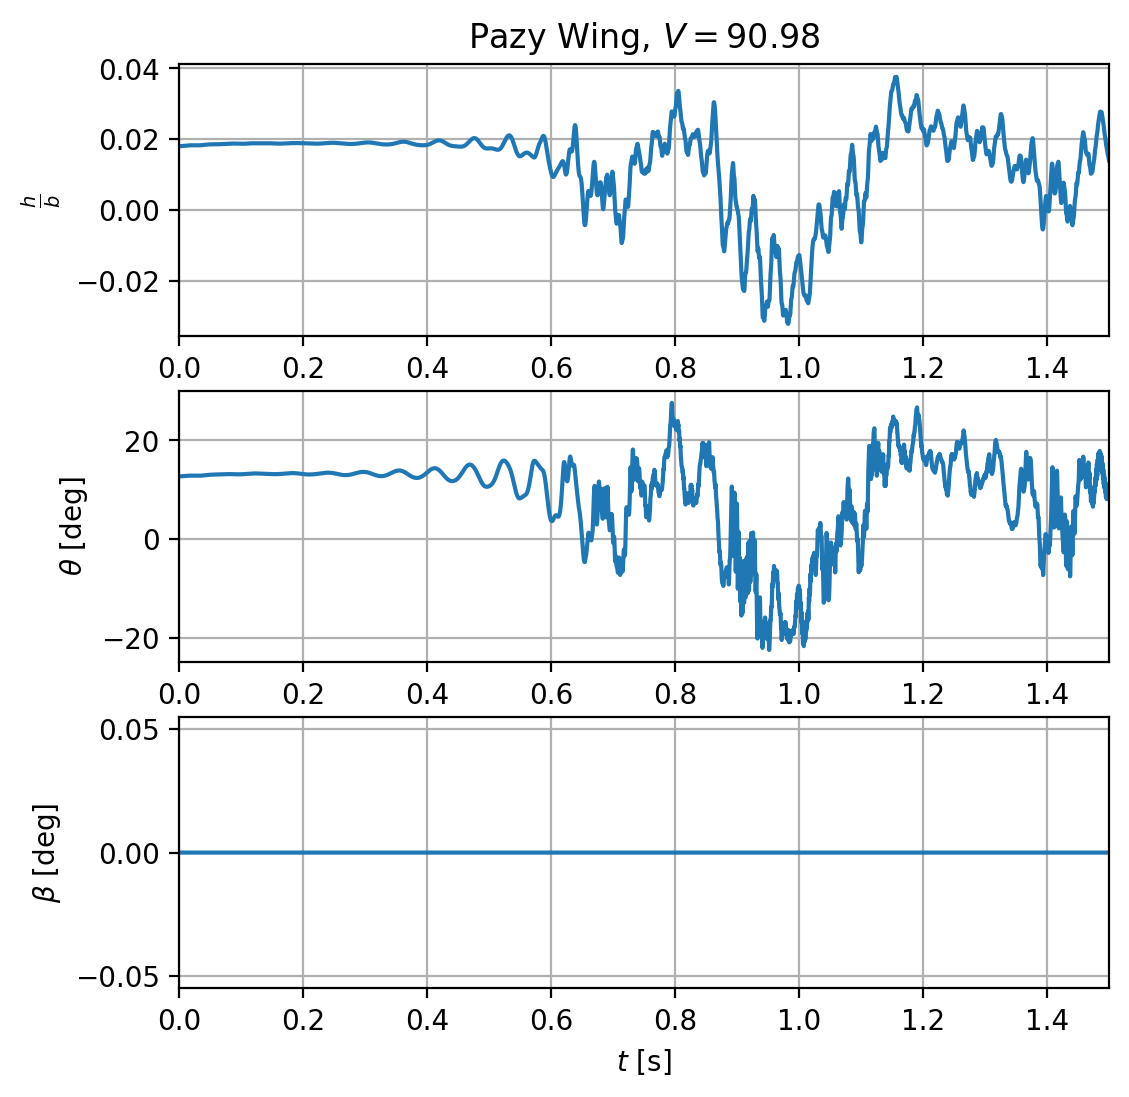

In [ ]:
# save nocontrol output to save some time
file_out = np.vstack([time, tip_pos_nocontrol, tip_rot_nocontrol, aileron]).T  # time, h, theta, beta
filename = ws.config['SHARPy']['log_folder'] + ws.case_name + '/tip_output.txt'
np.savetxt(filename, file_out, delimiter=',')
print(filename)

# plotting, optional (plotted in conjunction with controlled output below)
fig, ax = plt.subplots(3, figsize=(6, 6), dpi=200)

ax[0].plot(time, tip_pos_nocontrol / ws.b_ref, '-')
ax[1].plot(time, tip_rot_nocontrol, '-')
ax[2].plot(time, aileron, '-')

if not pazy: ax[0].set_title(r'Goland Wing, $V = {}$'.format(u_true))
else: ax[0].set_title(r'Pazy Wing, $V = {}$'.format(u_true))
ax[0].set_xlim(0, end_time)
ax[1].set_xlim(0, end_time)
ax[2].set_xlim(0, end_time)

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[2].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"$\frac{h}{b}$")
ax[1].set_ylabel(r'$\theta$ [deg]')
ax[2].set_ylabel(r'$\beta$ [deg]')

ustr = str(round(vf, 3)).replace('.', '_')
#     plt.savefig('../Desktop/goland_vf_m{}n{}ms{}_nocontrol.png'.format(M, N, M_star_fact))
plt.show()

In [ ]:
dir(sharpy_output_nocontrol.structure.timestep_info[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cag',
 'cga',
 'change_to_global_AFoR',
 'change_to_local_AFoR',
 'compute_psi_local_AFoR',
 'copy',
 'dqddt',
 'dqdt',
 'euler_angles',
 'extract_resultants',
 'for_acc',
 'for_pos',
 'for_vel',
 'forces_constraints_FoR',
 'forces_constraints_nodes',
 'get_body',
 'glob_pos',
 'gravity_forces',
 'in_global_AFoR',
 'mb_FoR_acc',
 'mb_FoR_pos',
 'mb_FoR_vel',
 'mb_dict',
 'mb_dquatdt',
 'mb_quat',
 'nodal_b_for_2_a_for',
 'nodal_type_b_for_2_a_for',
 'num_elem',
 'num_node',
 'num_node_elem',
 'pos',
 'pos_ddot',
 'pos_dot',
 'postproc_cell',
 'postproc_node',
 'psi',
 'psi_ddot',
 'psi_dot',
 'psi_dot_local',
 'psi_local

# Now run with controller

In [ ]:
# Compute the number of time steps needed based on the previous parameters
# Time discretization
u_inf = 1
u_true = vf
end_time = 1.5                 # End time of the simulation
dt = c_ref/N/u_true  # Always keep one timestep per panel
time_steps = int(end_time/dt)
if aero == 'StepLinearUVLM':
    u = u_inf
elif aero == 'StepUvlm':
    u = u_true
controlled = True
    
# ws = wings.GolandControlSurface(M=M,
#                                 N=N,
#                                 Mstar_fact=M_star_fact,
#                                 u_inf=u,
#                                 alpha=alpha_deg,
#                                 cs_deflection=[0, 0],
#                                 rho=rho,
#                                 sweep=0,
#                                 physical_time=end_time,
#                                 n_surfaces=n_surfaces,
#                                 route=route_test_dir + '/cases',
#                                 case_name=case_name+'_controlled',
#                                 pct_flap=flap_frac,  # fraction of span of flap
#                                 )

ws = wings.PazyControlSurface(M=M,
                                N=N,
                                Mstar_fact=M_star_fact,
                                u_inf=u,
                                alpha=alpha_deg,
                                cs_deflection=[0],
                                rho=rho,
                                physical_time=end_time,
                                n_surfaces=n_surfaces,
                                route=route_test_dir + '/cases',
                                case_name=case_name,
                                pct_flap=flap_frac,  # fraction of span of flap
                                )

# Default values initialisation
ws.clean_test_files()
ws.update_derived_params()
ws.set_default_config_dict()

# UPDATE ALL CUSTOM PARAMS BELOW
ws.dt = dt
ws.n_tstep = time_steps
ws.control_surface_chord = ws.M // 4 * np.ones(ws.n_control_surfaces, dtype=int)  # quarter chord (default is half chord)
if controlled:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 2  # 0=static, 1=dynamic, 2=controlled
else:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 0
# UPDATE ALL CUSTOM PARAMS ABOVE

ws.generate_aero_file()
ws.generate_fem_file()


ws.config['SHARPy'] = {
    'flow':
        ['BeamLoader',
         'AerogridLoader',
         'StaticCoupled',
         'AerogridPlot',
         'BeamPlot',
         'DynamicCoupled',
         ],
    'case': ws.case_name, 'route': ws.route,
    'write_screen': 'on', 'write_log': 'on',
    'log_folder': route_test_dir + '/output/controlled/',
    'log_file': ws.case_name + '.log'}
ws.config['SHARPy']
try:
    os.mkdir(ws.config['SHARPy']['log_folder'])
except:
    pass
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.config['SHARPy']['case'])
except FileExistsError:
    pass

ws.config['BeamLoader'] = {
    'unsteady': True,
    'orientation': ws.quat}

# Dynamic control surface input, use same file as controller input
try:
    os.mkdir(ws.config['SHARPy']['log_folder'])
except FileExistsError:
    pass
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller')
except FileExistsError:
    pass
x = np.zeros([time_steps, 1])
np.savetxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt', x, delimiter=',')

csdict = {'deflection_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt',
          'dt': ws.dt,
         }
ws.config['AerogridLoader'] = {'unsteady': True,
                                'aligned_grid': 'on',
                                'mstar': ws.Mstar_fact * ws.M,
                                'freestream_dir': ws.u_inf_direction,
                                'wake_shape_generator': 'StraightWake',
                                'wake_shape_generator_input': {'u_inf': ws.u_inf,
                                                                'u_inf_direction': ws.u_inf_direction,
                                                                'dt': ws.dt},
                               #'control_surface_deflection': ['DynamicControlSurface', 'DynamicControlSurface'],
                               #'control_surface_deflection_generator_settings': {'0': csdict,
                               #                                                  '1': csdict,
                               #                                                  }
                            }
# ws.config['AerogridLoader']

ws.config['StaticCoupled'] = {
    'print_info': 'on',
    'max_iter': 200,
    'n_load_steps': 1,
    'tolerance': 1e-10,
    'relaxation_factor': 0.,
    'aero_solver': 'StaticUvlm',
    'aero_solver_settings': {
        'rho': ws.rho,
        'print_info': 'off',
        'horseshoe': 'off',
        'num_cores': num_cores,
        'n_rollup': 0,
        'rollup_dt': ws.dt,
        'rollup_aic_refresh': 1,
        'rollup_tolerance': 1e-4,
        'velocity_field_generator': 'SteadyVelocityField',
        'velocity_field_input': {
            'u_inf': ws.u_inf,
            'u_inf_direction': ws.u_inf_direction}},
    'structural_solver': 'NonLinearStatic',
    'structural_solver_settings': {'print_info': 'off',
                                   'max_iterations': 150,
                                   'num_load_steps': 4,
                                   'delta_curved': 1e-1,
                                   'min_delta': 1e-10,
                                   'gravity_on': 'on',
                                   'gravity': 9.81},
}

## PID Controller Parameters

In [ ]:
P = 0.05  # Reduce rise time, increase overshoot, reduce steady state error (P >= 6 introduces an unstable low freq mode)
I = 1  # Reduce rise time, increase overshoot, increase settling time, reduce steady state error (less sensitive, should be zero or negative, positive I results in drifting away)
D = 0.0001  # Reduce overshoot, Reduce settling time (value must be small, very sensitive, must be negative)

# controller noise
noise = False
noise_settings = {'noise_mode': 'amplitude', 'max_percentage': 10, 'max_amplitude': np.radians(25),}

# controller lag
T = 0.07173323075943051  # oscillation period from previous runs
# lag_ms = 0.5 * T * 1000
lag_ms = 0
lag_s = lag_ms / 1000  # apply lag (s)
lag = int(lag_s / dt)  # lag in time steps, input 0 or 1 for default (no lag)


#### Dynamic Coupled Solver

In [ ]:
ws.config['DynamicCoupled']['dt'] = dt
ws.config['DynamicCoupled']['n_time_steps'] = time_steps
ws.config['DynamicCoupled']['print_info'] = True
ws.config['DynamicCoupled']['fsi_substeps'] = fsi_steps
ws.config['DynamicCoupled']['fsi_tolerance'] = fsi_tol
ws.config['DynamicCoupled']['dynamic_relaxation'] = False
ws.config['DynamicCoupled']['relaxation_steps'] = relax_steps
ws.config['DynamicCoupled']['relaxation_factor'] = relax_fact
# ws.config['DynamicCoupled']['final_relaxation_factor'] = 0.5

ws.config['DynamicCoupled']['structural_solver_settings']['gravity_on'] = False
ws.config['DynamicCoupled']['structural_solver_settings']['dt'] = dt
ws.config['DynamicCoupled']['structural_solver_settings']['num_steps'] = time_steps

ws.config['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
'''
ws.config['DynamicCoupled']['postprocessors'] = {"BeamPlot": {"include_rbm": "on", "include_applied_forces": "on"},
                                                 "AerogridPlot": {"u_inf": ws.u_inf,
                                                                "include_rbm": "on",
                                                                "include_applied_forces": "on",
                                                                "minus_m_star": 0,}
                                                }'''

ws.config['DynamicCoupled']['aero_solver'] = aero
if aero == 'StepLinearUVLM':
    ws.config['DynamicCoupled']['aero_solver_settings'] = {}
    ws.config['DynamicCoupled']['aero_solver_settings']['integr_order'] = intg_order
    ws.config['DynamicCoupled']['aero_solver_settings']['density'] = ws.rho
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}
    ws.config['DynamicCoupled']['aero_solver_settings']['ScalingDict'] = {'speed': u_true, 'length': c_ref, 'density': ws.rho}
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
elif aero == 'StepUvlm':
    ws.config['DynamicCoupled']['aero_solver_settings']['num_cores'] = num_cores
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
    ws.config['DynamicCoupled']['aero_solver_settings']['n_time_steps'] = time_steps
    ws.config['DynamicCoupled']['aero_solver_settings']['convection_scheme'] = conv_scheme
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}

# CONTROLLER IMPLEMENTATION
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller')
except FileExistsError:
    pass
x = np.full([time_steps, 1], ws.alpha_rad)
np.savetxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt', x, delimiter=',')

if controlled:
    ws.config['DynamicCoupled']['controller_id'] = {'aileron': 'ControlSurfacePidController'}
    ws.config['DynamicCoupled']['controller_settings'] = {'aileron': {'P': P,
                                                                      'I': I,
                                                                      'D': D,
                                                                      'dt': dt,
                                                                      'controlled_surfaces': [0, 1],
                                                                      'write_controller_log': True,
                                                                      'input_type': 'tip rotation',
                                                                      'time_history_input_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt',
                                                                      'controller_log_route': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/',
                                                                      'controller_noise': noise,
                                                                      'controller_noise_settings': noise_settings,
                                                                      'controller_lag': lag,
                                                                      'output_limit': np.radians(25),  # IN RADIANS, -1 if no limit
                                                                     }
                                                         }


#for k, v in ws.config['DynamicCoupled'].items():
#    print(k, v)
#print('\nWing Properties:\n', vars(ws))

ws.config.write()
print(ws.route + ws.case_name)

/home/ansley/sharpy/cases/pazy_csM4N8Ms10_nmodes8rom_MIMORA_r12_sig0000_0000j


In [ ]:
sharpy_output = sharpy_control.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ansley/sharpy
SHARPy being run is in /home/ansley/sharpy
The branch being run is develop
The version and commit hash are: 2.0-309-g362cd337-362cd337
SHARPy outp

|  2  |  0  |  -2.63794  | -0.4876  |  0.0224  | 65.5634  | -0.0099  |  1.3909  | -0.0015  |
|  3  |  0  |  -2.87891  | -0.5986  |  0.0510  | 70.3551  | -0.0209  |  1.4645  | -0.0026  |
|  4  |  0  |  -3.20155  | -0.6533  |  0.0753  | 72.3992  | -0.0298  |  1.4939  | -0.0034  |
|  5  |  0  |  -3.56500  | -0.6774  |  0.0905  | 73.2419  | -0.0353  |  1.5055  | -0.0039  |
|  6  |  0  |  -3.94728  | -0.6875  |  0.0988  | 73.5840  | -0.0383  |  1.5102  | -0.0042  |
|  7  |  0  |  -4.33770  | -0.6916  |  0.1028  | 73.7220  | -0.0397  |  1.5120  | -0.0043  |
|  8  |  0  |  -4.73153  | -0.6933  |  0.1047  | 73.7775  | -0.0404  |  1.5128  | -0.0043  |
|  9  |  0  |  -5.12674  | -0.6939  |  0.1056  | 73.7998  | -0.0407  |  1.5131  | -0.0044  |
| 10  |  0  |  -5.52251  | -0.6942  |  0.1059  | 73.8088  | -0.0409  |  1.5132  | -0.0044  |
| 11  |  0  |  -5.91849  | -0.6943  |  0.1061  | 73.8124  | -0.0409  |  1.5133  | -0.0044  |
| 12  |  0  |  -6.31455  | -0.6943  |  0.1062  | 73.8139  | -0.0410  |

### Read controller output from csv

In [ ]:
data = np.genfromtxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/'+ws.config['DynamicCoupled']['controller_id'].keys()[0]+'.log.csv', delimiter=',')
tstep = data[:, 0]
tctrl = data[:, 1]
desired = np.degrees(data[:, 2])
current = np.degrees(data[:, 3])
pctrl = np.degrees(data[:, 4])
ictrl = np.degrees(data[:, 5])
dctrl = np.degrees(data[:, 6])
nctrl = np.degrees(data[:, 7])
cap_ctrl = data[:, 8]
rctrl = np.degrees(data[:, 9])
ctrl = np.degrees(data[:, -1])
print(tstep)
print(tctrl)
print(desired)
print(current)
print(dctrl)
print(ctrl)

[1.0000e+00 2.0000e+00 3.0000e+00 ... 1.0915e+04 1.0916e+04 1.0917e+04]
[1.370000e-04 2.750000e-04 4.120000e-04 ... 1.499643e+00 1.499780e+00 1.499918e+00]
[0.99998324 0.99998324 0.99998324 ... 0.99998324 0.99998324 0.99998324]
[12.70843308 12.70843308 12.70849037 ... 20.31427592 20.02785432 20.0104937 ]
[ 0.00000000e+00 -0.00000000e+00 -5.72957795e-05 ...  3.45951917e-01  1.32066772e-01 -8.53134157e-02]
[-1.17083925 -1.17083925 -1.17089655 ... -1.58548881 -1.77072607 -1.98638738]


### Defining metrics for control response

In [ ]:
def amp(tseries):  # returns max average amplitude of wave-like time series
    _max = max(tseries)
    _min = min(tseries)
    avgmax = abs(_max - _min) / 2
    offset = np.mean([_max, _min])
    return avgmax, offset


def period(time, tseries):  # returns period of oscillation
    peaks = sig.find_peaks(tseries)[0]  # returns indices of peaks
    tpeak = time[peaks]
    intervals = np.diff(tpeak)
    return np.mean(intervals)


def peakfit(time, tseries):  # fits a decay function to the peaks
    peaks = sig.find_peaks(tseries)[0]  # returns indices of peaks
    tpeak = time[peaks]
    tspeak = tseries[peaks]
    def testfunc(x, a, b):  # test function, exponential decay here, x here corresponds to t
        return a * np.exp(b * x)
    popt, pcov = opt.curve_fit(testfunc, tpeak, tspeak)
    y = testfunc(time, *popt)
    return y, popt

### Plotting

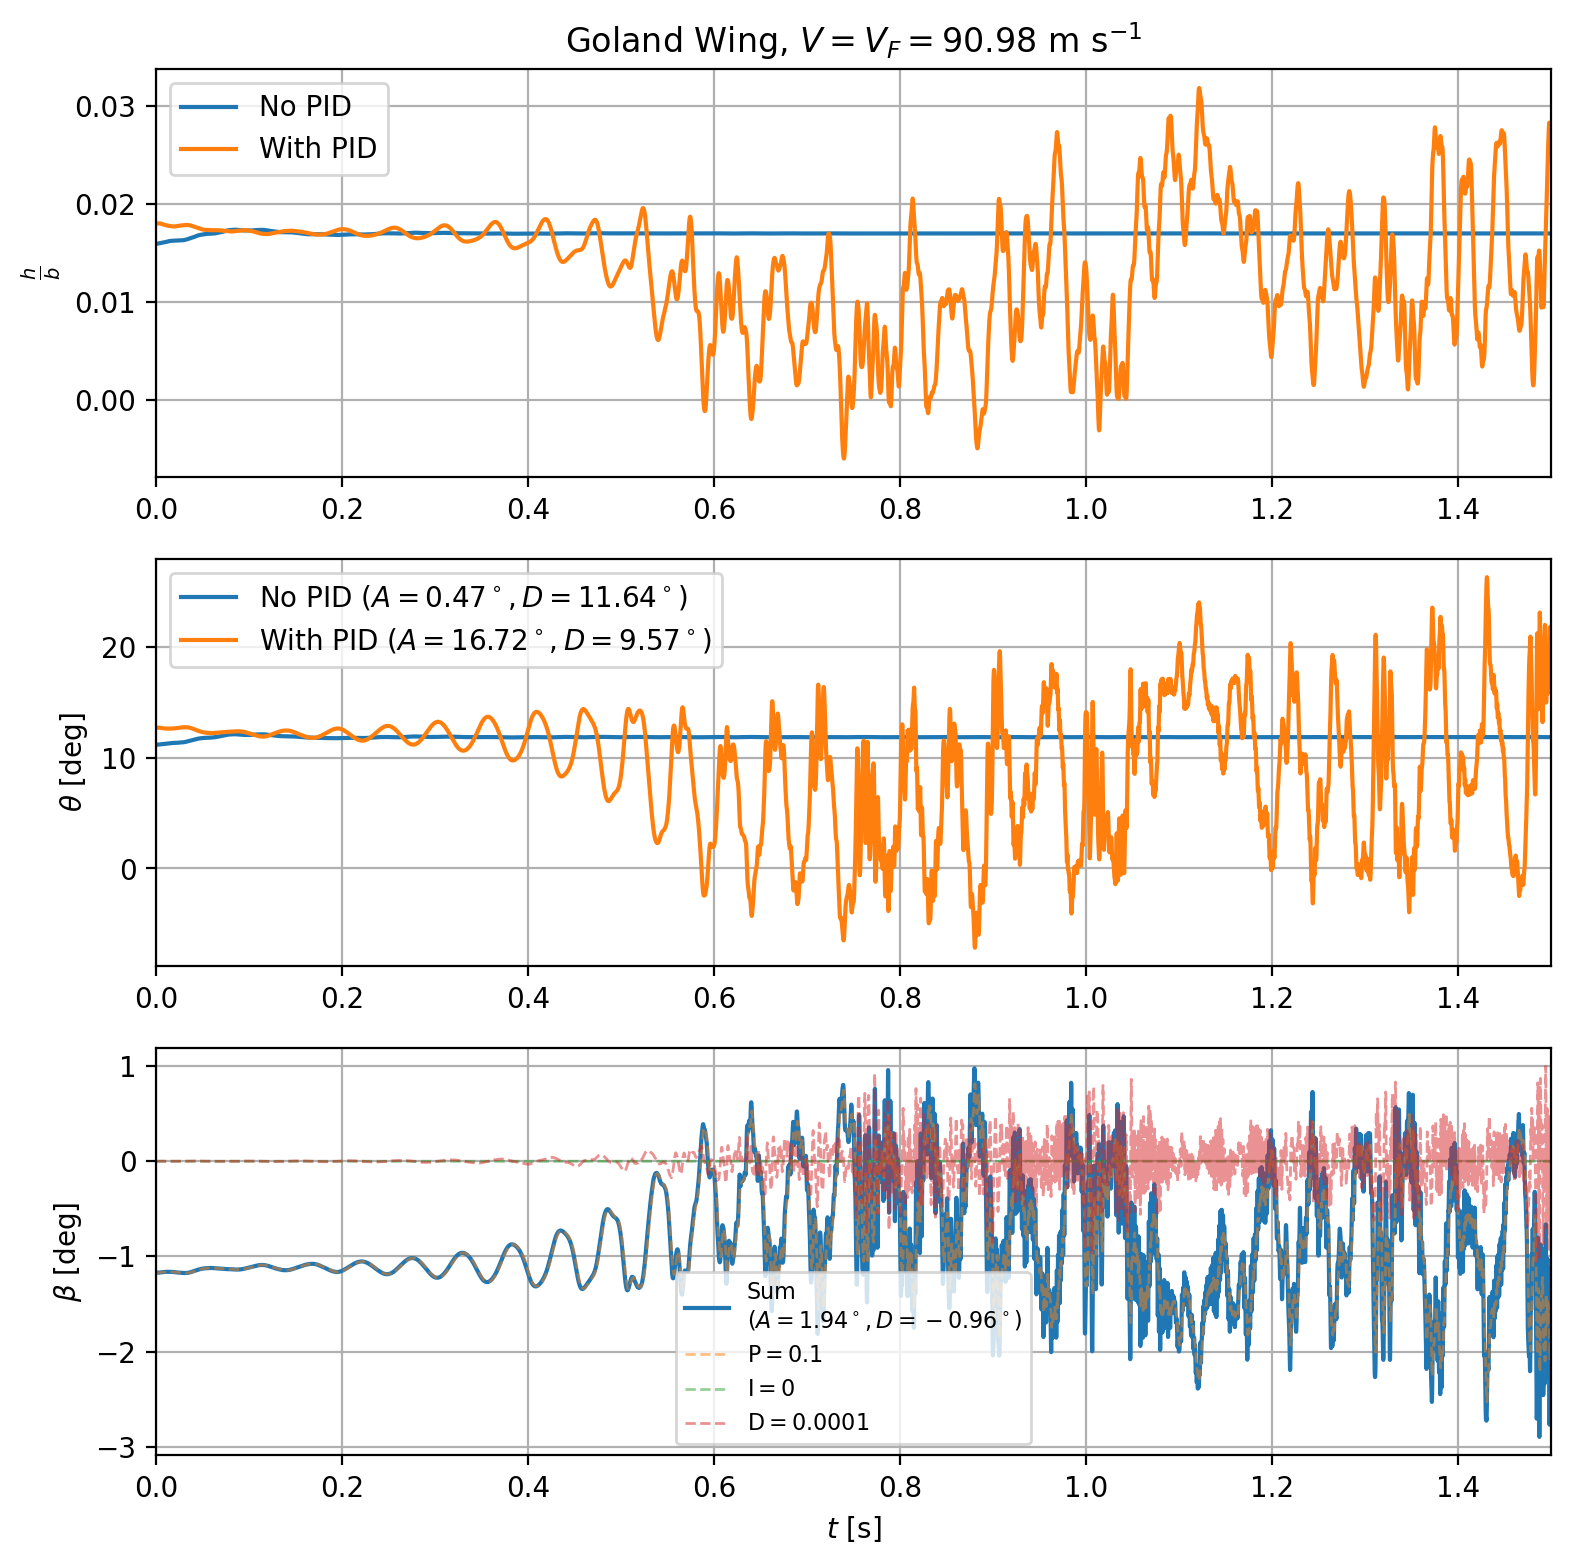

In [ ]:
# load original output from file (saves time from nocontrol sim)
filename = nocontrol_output_dir + 'tip_output.txt'
a = np.loadtxt(filename, delimiter=',')
t_nocontrol = a[:, 0]
tip_pos_nocontrol = a[:, 1]
tip_rot_nocontrol = a[:, 2]

time = np.linspace(0, dt*time_steps, time_steps)
tip_pos = np.zeros((time_steps))
tip_rot = np.zeros((time_steps))
aileron = np.zeros((time_steps))
tip_pos[tip_pos==0] = None
tip_rot[tip_rot==0] = None
aileron[aileron==0] = None
for it in range(0, len(time)):  # fill values up to latest timestep, does not necessarily be all timesteps if iteration ended early due to errors
    try:
        tip_pos[it] = sharpy_output.structure.timestep_info[it].pos[-1, 2]
        tip_rot[it] = sharpy_output.structure.timestep_info[it].psi[-1, -1, 1]
    except IndexError:
        pass
    try:
        aileron[it] = sharpy_output.aero.timestep_info[it].control_surface_deflection[0]
    except:
        pass

tip_rot = np.degrees(tip_rot)
aileron = np.degrees(aileron)

'''print(rctrl)
print(ctrl)
print(aileron)
print(ctrl.shape)
print(aileron.shape)'''

# amplitude and offset
amp_nocontrol, off_nocontrol = amp(tip_rot_nocontrol)
amp_control, off_control = amp(tip_rot)
amp_aileron, off_aileron = amp(ctrl)
amp_raw, off_raw = amp(rctrl)

# identifying peaks
tip_rot_peaks = sig.find_peaks(tip_rot)[0]
# tip_rot_nocontrol_peaks = sig.find_peaks(tip_rot_nocontrol)[0]

'''tipfit, params = peakfit(time, np.radians(tip_rot))
tipfit = np.degrees(tipfit)
osc_period = period(time, tip_rot)
print(params)
'''
# Plotting
fig, ax = plt.subplots(3, figsize=(9, 9), dpi=200)

ax[0].plot(t_nocontrol, tip_pos_nocontrol / ws.b_ref, '-', label='No PID')
ax[0].plot(time, tip_pos / ws.b_ref, '-', label='With PID')

ax[1].plot(t_nocontrol, tip_rot_nocontrol, '-', label=r'No PID $(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_nocontrol, r'\circ', off_nocontrol, r'\circ'))
# ax[1].plot(time, tip_rot, '-', label='With PID\n'+r'$A = {:.2f}$, $\theta = {:.3f} \exp ({:.3f}t)$'.format(amp(tip_rot)[0], params[0], params[1]))
ax[1].plot(time, tip_rot, '-', label=r'With PID ($A = {:.2f}^{}, D = {:.2f}^{}$)'.format(amp_control, r'\circ', off_control, r'\circ'))
# ax[1].plot(time[tip_rot_nocontrol_peaks], tip_rot_nocontrol[tip_rot_nocontrol_peaks], 'x')
# ax[1].plot(time[tip_rot_peaks], tip_rot[tip_rot_peaks], 'x')
# ax[1].plot(time, tipfit, alpha=0.5, linewidth=1)

if (rctrl == ctrl).all():
    ax[2].plot(tctrl, ctrl, '-', label='Sum\n'+r'$(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_aileron, r'\circ', off_aileron, r'\circ'))
else:
    ax[2].plot(tctrl, rctrl, '-', label='Sum (raw) '+r'$(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_raw, r'\circ', off_raw, r'\circ'))
    ax[2].plot(tctrl, ctrl, '-', label='Sum (capped) '+r'$(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_aileron, r'\circ', off_aileron, r'\circ'))
ax[2].plot(tctrl, pctrl, '--', label=r'P$={}$'.format(P), alpha=0.5, linewidth=1)
ax[2].plot(tctrl, ictrl, '--', label=r'I$={}$'.format(I), alpha=0.5, linewidth=1)
ax[2].plot(tctrl, dctrl, '--', label=r'D$={}$'.format(D), alpha=0.5, linewidth=1)
ax[2].set_xlim(0, end_time)
#ax[2].set_ylim(-1, 1)
#ax[1].plot(time, np.degrees(current))
#ax[2].plot(time, np.degrees(aileron))

# ax2t = ax[2].twinx()
# ax2t.plot(tctrl, cap_ctrl, 'C4', label='Output capping', alpha=0.5)
# ax2t.set_xlim(0, end_time)
# ax2t.set_ylim(-1.1, 1.1)

# prepare noise string
if noise_settings['noise_mode'] == 'percentage':
    noisestr = '{}'.format(noise_settings['max_percentage']) + r'%'
elif noise_settings['noise_mode'] == 'amplitude':
    noisestr = '{}'.format(np.degrees(noise_settings['max_amplitude'])) + '$^{\circ}$'

if noise and lag == 0:
    ax[0].set_title(r'Goland Wing, $V = V_F = {:.2f}$ '.format(vf) + 'm s$^{-1}$' + ', with max. {} controller noise'.format(noisestr))
elif noise and lag > 0:
    ax[0].set_title(r'Goland Wing, $V = V_F = {:.2f}$ ' + 'm s$^{-1}$' + ', with controller noise, controller lag = {} ms'.format(round(lag_ms)))
elif noise is False and lag > 0:
    ax[0].set_title(r'Goland Wing, $V = V_F = {:.2f}$ '.format(vf) + 'm s$^{-1}$' + ', controller lag = {} ms'.format(round(lag_ms)))
else:
    ax[0].set_title(r'Goland Wing, $V = V_F = {:.2f}$'.format(vf)+' m s$^{-1}$')
ax[0].set_xlim(0, end_time)
ax[1].set_xlim(0, end_time)
ax[2].set_xlim(0, end_time)

# ax[1].set_ylim(-1, 1)


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[2].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"$\frac{h}{b}$")
ax[1].set_ylabel(r'$\theta$ [deg]')
ax[2].set_ylabel(r'$\beta$ [deg]')
ax[0].legend()
ax[1].legend()
ax[2].legend(loc=0, fontsize=8)

# prepare strings for saving files
ustr = str(round(vf, 3)).replace('.', '_')
pstr = str(P).replace('.', '_')
istr = str(I).replace('.', '_')
dstr = str(D).replace('.', '_')
lstr = str(round(lag_ms)).replace('.', '_')
if noise_settings['noise_mode'] == 'percentage':
    nstr = ('{}pct'.format(noise_settings['max_percentage'])).replace('.', '_')
elif noise_settings['noise_mode'] == 'amplitude':
    nstr = ('{}deg'.format(np.degrees(noise_settings['max_amplitude']))).replace('.', '_')

# if noise and lag == 0:
#     plt.savefig('../Desktop/flutter_control/goland_vf_m{}n{}ms{}_control_p{}i{}d{}_noise{}.png'.format(M, N, M_star_fact, pstr, istr, dstr, nstr))
# elif noise and lag > 0:
#     plt.savefig('../Desktop/flutter_control/goland_vf_m{}n{}ms{}_control_p{}i{}d{}_noise{}_lag{}ms.png'.format(M, N, M_star_fact, pstr, istr, dstr, nstr, lstr))
# elif noise is False and lag > 0:
#     plt.savefig('../Desktop/flutter_control/goland_vf_m{}n{}ms{}_control_p{}i{}d{}_lag{}ms.png'.format(M, N, M_star_fact, pstr, istr, dstr, lstr))
# else:
#     plt.savefig('../Desktop/flutter_control/goland_vf_m{}n{}ms{}_control_p{}i{}d{}.png'.format(M, N, M_star_fact, pstr, istr, dstr))
plt.show()

# Run dynamic analysis with higher velocity to evaluate controller robustness

In [ ]:
u_true = 1.1 * vf
mult = u_true / vf
print(u_true, mult)
end_time = 5

103.93900000000002 1.1


## First run without controller (control setup)

In [ ]:
# Compute the number of time steps needed based on the previous parameters
# Time discretization
u_inf = 1
dt = c_ref/N/u_true  # Always keep one timestep per panel
time_steps = int(end_time/dt)
if aero == 'StepLinearUVLM':
    u = u_inf
elif aero == 'StepUvlm':
    u = u_true
controlled = False  # this is a control setup, without controller (static control surface)
    
ws = wings.GolandControlSurface(M=M,
                                N=N,
                                Mstar_fact=M_star_fact,
                                u_inf=u,
                                alpha=alpha_deg,
                                cs_deflection=[0, 0],
                                rho=rho,
                                sweep=0,
                                physical_time=end_time,
                                n_surfaces=n_surfaces,
                                route=route_test_dir + '/cases',
                                case_name=case_name + '_v' + str(u_true),
                                pct_flap=flap_frac,  # fraction of span of flap
                                )

# Default values initialisation
ws.clean_test_files()
ws.update_derived_params()
ws.set_default_config_dict()

# UPDATE ALL CUSTOM PARAMS BELOW
ws.dt = dt
ws.n_tstep = time_steps
ws.control_surface_chord = ws.M // 4 * np.ones(ws.n_control_surfaces, dtype=int)  # quarter chord (default is half chord)
if controlled:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 2  # 0=static, 1=dynamic, 2=controlled
else:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 0
# UPDATE ALL CUSTOM PARAMS ABOVE

ws.generate_aero_file()
ws.generate_fem_file()


ws.config['SHARPy'] = {
    'flow':
        ['BeamLoader',
         'AerogridLoader',
         'StaticCoupled',
         'AerogridPlot',
         'BeamPlot',
         'DynamicCoupled',
         ],
    'case': ws.case_name, 'route': ws.route,
    'write_screen': 'on', 'write_log': 'on',
    'log_folder': route_test_dir + '/output/',
    'log_file': ws.case_name + '.log'}
ws.config['SHARPy']
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.config['SHARPy']['case'])
except FileExistsError:
    pass

ws.config['BeamLoader'] = {
    'unsteady': True,
    'orientation': ws.quat}

csdict = {'deflection_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}/input.txt'.format(u_true),
          'dt': ws.dt,
         }
ws.config['AerogridLoader'] = {'unsteady': True,
                                'aligned_grid': 'on',
                                'mstar': ws.Mstar_fact * ws.M,
                                'freestream_dir': ws.u_inf_direction,
                                'wake_shape_generator': 'StraightWake',
                                'wake_shape_generator_input': {'u_inf': ws.u_inf,
                                                                'u_inf_direction': ws.u_inf_direction,
                                                                'dt': ws.dt},
                               #'control_surface_deflection': ['DynamicControlSurface', 'DynamicControlSurface'],
                               #'control_surface_deflection_generator_settings': {'0': csdict,
                               #                                                  '1': csdict,
                               #                                                  }
                            }


ws.config['StaticCoupled'] = {
    'print_info': 'on',
    'max_iter': 200,
    'n_load_steps': 1,
    'tolerance': 1e-10,
    'relaxation_factor': 0.,
    'aero_solver': 'StaticUvlm',
    'aero_solver_settings': {
        'rho': ws.rho,
        'print_info': 'off',
        'horseshoe': 'off',
        'num_cores': num_cores,
        'n_rollup': 0,
        'rollup_dt': ws.dt,
        'rollup_aic_refresh': 1,
        'rollup_tolerance': 1e-4,
        'velocity_field_generator': 'SteadyVelocityField',
        'velocity_field_input': {
            'u_inf': ws.u_inf,
            'u_inf_direction': ws.u_inf_direction}},
    'structural_solver': 'NonLinearStatic',
    'structural_solver_settings': {'print_info': 'off',
                                   'max_iterations': 150,
                                   'num_load_steps': 4,
                                   'delta_curved': 1e-1,
                                   'min_delta': 1e-10,
                                   'gravity_on': 'on',
                                   'gravity': 9.81},
}

ws.config['DynamicCoupled']['dt'] = dt
ws.config['DynamicCoupled']['n_time_steps'] = time_steps
ws.config['DynamicCoupled']['print_info'] = True
ws.config['DynamicCoupled']['fsi_substeps'] = fsi_steps
ws.config['DynamicCoupled']['fsi_tolerance'] = fsi_tol
ws.config['DynamicCoupled']['dynamic_relaxation'] = False
ws.config['DynamicCoupled']['relaxation_steps'] = relax_steps
ws.config['DynamicCoupled']['relaxation_factor'] = relax_fact
# ws.config['DynamicCoupled']['final_relaxation_factor'] = 0.5

ws.config['DynamicCoupled']['structural_solver_settings']['gravity_on'] = False
ws.config['DynamicCoupled']['structural_solver_settings']['dt'] = dt
ws.config['DynamicCoupled']['structural_solver_settings']['num_steps'] = time_steps

ws.config['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
'''
ws.config['DynamicCoupled']['postprocessors'] = {"BeamPlot": {"include_rbm": "on", "include_applied_forces": "on"},
                                                 "AerogridPlot": {"u_inf": ws.u_inf,
                                                                "include_rbm": "on",
                                                                "include_applied_forces": "on",
                                                                "minus_m_star": 0,}
                                                }'''

ws.config['DynamicCoupled']['aero_solver'] = aero
if aero == 'StepLinearUVLM':
    ws.config['DynamicCoupled']['aero_solver_settings'] = {}
    ws.config['DynamicCoupled']['aero_solver_settings']['integr_order'] = intg_order
    ws.config['DynamicCoupled']['aero_solver_settings']['density'] = ws.rho
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}
    ws.config['DynamicCoupled']['aero_solver_settings']['ScalingDict'] = {'speed': u_true, 'length': c_ref, 'density': ws.rho}
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
elif aero == 'StepUvlm':
    ws.config['DynamicCoupled']['aero_solver_settings']['num_cores'] = num_cores
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
    ws.config['DynamicCoupled']['aero_solver_settings']['n_time_steps'] = time_steps
    ws.config['DynamicCoupled']['aero_solver_settings']['convection_scheme'] = conv_scheme
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}

# CONTROLLER IMPLEMENTATION
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller')
except FileExistsError:
    pass
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}'.format(u_true))
except FileExistsError:
    pass
x = np.zeros([time_steps, 1])
np.savetxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}/input.txt'.format(u_true), x, delimiter=',')

if controlled:
    ws.config['DynamicCoupled']['controller_id'] = {'aileron': 'ControlSurfacePidController'}
    ws.config['DynamicCoupled']['controller_settings'] = {'aileron': {'P': P,
                                                                      'I': I,
                                                                      'D': D,
                                                                      'dt': dt,
                                                                      'controlled_surfaces': [0, 1],
                                                                      'write_controller_log': True,
                                                                      'input_type': 'tip rotation',
                                                                      'time_history_input_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}/input.txt'.format(u_true),
                                                                      'controller_log_route': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}'.format(u_true),
                                                                      'controller_lag': lag,
                                                                     }
                                                         }
else:
    pass

#for k, v in ws.config['DynamicCoupled'].items():
#    print(k, v)
#print('\nWing Properties:\n', vars(ws))

ws.config.write()
nocontrol_output_dir = ws.config['SHARPy']['log_folder'] + ws.case_name + '/'
print(ws.route + ws.case_name)
print(nocontrol_output_dir)

/home/ansley/sharpy/cases/pazy_csM4N8Ms10_nmodes8rom_MIMORA_r6_sig0000_0000j_v103.93900000000002
/home/ansley/sharpy/output/pazy_csM4N8Ms10_nmodes8rom_MIMORA_r6_sig0000_0000j_v103.93900000000002/


In [ ]:
# %%capture capt
try:  # skip simulation if nocontrol sim has been run previously
    filename = nocontrol_output_dir + 'tip_output.txt'
    a = np.loadtxt(filename, delimiter=',')
    tip_pos_nocontrol = a[:, 1]
    tip_rot_nocontrol = a[:, 2]

except:  # run sim if output file is not found
    sharpy_output_nocontrol = sharpy_control.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])

    time = np.linspace(0, dt*time_steps, time_steps)

    tip_pos_nocontrol = np.zeros((time_steps))
    tip_rot_nocontrol = np.zeros((time_steps))
    aileron = np.zeros((time_steps))
    for it in range(time_steps):
        tip_pos_nocontrol[it] = sharpy_output_nocontrol.structure.timestep_info[it].pos[-1, 2]
        tip_rot_nocontrol[it] = sharpy_output_nocontrol.structure.timestep_info[it].psi[-1, -1, 1]
    tip_rot_nocontrol = np.degrees(tip_rot_nocontrol)
    aileron = np.degrees(aileron)

    # save nocontrol output to save some time
    file_out = np.vstack([time, tip_pos_nocontrol, tip_rot_nocontrol, aileron]).T  # time, h, theta, beta
    filename = ws.config['SHARPy']['log_folder'] + ws.case_name + '/tip_output.txt'
    np.savetxt(filename, file_out, delimiter=',')
    print(filename)


--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ansley/sharpy
SHARPy being run is in /home/ansley/sharpy
The branch being run is develop
The version and commit hash are: 2.0-309-g362cd337-362cd337
SHARPy outp

KeyboardInterrupt: 

# Now run with controller

In [ ]:
# Compute the number of time steps needed based on the previous parameters
# Time discretization
u_inf = 1
# u_true = vf
# end_time = 2                 # End time of the simulation
dt = 1.8288/N/u_true  # Always keep one timestep per panel
time_steps = int(end_time/dt)
if aero == 'StepLinearUVLM':
    u = u_inf
elif aero == 'StepUvlm':
    u = u_true
controlled = True
    
ws = wings.GolandControlSurface(M=M,
                                N=N,
                                Mstar_fact=M_star_fact,
                                u_inf=u,
                                alpha=alpha_deg,
                                cs_deflection=[0, 0],
                                rho=rho,
                                sweep=0,
                                physical_time=end_time,
                                n_surfaces=n_surfaces,
                                route=route_test_dir + '/cases',
                                case_name=case_name+'_v{}_controlled'.format(u_true),
                                pct_flap=flap_frac,  # fraction of span of flap
                                )
# Default values initialisation
ws.clean_test_files()
ws.update_derived_params()
ws.set_default_config_dict()

# UPDATE ALL CUSTOM PARAMS BELOW
ws.dt = dt
ws.n_tstep = time_steps
ws.control_surface_chord = ws.M // 4 * np.ones(ws.n_control_surfaces, dtype=int)  # quarter chord (default is half chord)
if controlled:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 2  # 0=static, 1=dynamic, 2=controlled
else:
    ws.control_surface_type = np.ones(ws.n_control_surfaces, dtype=int) * 0
# UPDATE ALL CUSTOM PARAMS ABOVE

ws.generate_aero_file()
ws.generate_fem_file()


ws.config['SHARPy'] = {
    'flow':
        ['BeamLoader',
         'AerogridLoader',
         'StaticCoupled',
         'AerogridPlot',
         'BeamPlot',
         'DynamicCoupled',
         ],
    'case': ws.case_name, 'route': ws.route,
    'write_screen': 'on', 'write_log': 'on',
    'log_folder': route_test_dir + '/output/controlled/',
    'log_file': ws.case_name + '.log'}
ws.config['SHARPy']
try:
    os.mkdir(ws.config['SHARPy']['log_folder'])
except:
    pass
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.config['SHARPy']['case'])
except FileExistsError:
    pass

ws.config['BeamLoader'] = {
    'unsteady': True,
    'orientation': ws.quat}

# Dynamic control surface input, use same file as controller input
try:
    os.mkdir(ws.config['SHARPy']['log_folder'])
except FileExistsError:
    pass
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller')
except FileExistsError:
    pass
x = np.zeros([time_steps, 1])
np.savetxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt', x, delimiter=',')

csdict = {'deflection_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/input.txt',
          'dt': ws.dt,
         }
ws.config['AerogridLoader'] = {'unsteady': True,
                                'aligned_grid': 'on',
                                'mstar': ws.Mstar_fact * ws.M,
                                'freestream_dir': ws.u_inf_direction,
                                'wake_shape_generator': 'StraightWake',
                                'wake_shape_generator_input': {'u_inf': ws.u_inf,
                                                                'u_inf_direction': ws.u_inf_direction,
                                                                'dt': ws.dt},
                               #'control_surface_deflection': ['DynamicControlSurface', 'DynamicControlSurface'],
                               #'control_surface_deflection_generator_settings': {'0': csdict,
                               #                                                  '1': csdict,
                               #                                                  }
                            }
# ws.config['AerogridLoader']

ws.config['StaticCoupled'] = {
    'print_info': 'on',
    'max_iter': 200,
    'n_load_steps': 1,
    'tolerance': 1e-10,
    'relaxation_factor': 0.,
    'aero_solver': 'StaticUvlm',
    'aero_solver_settings': {
        'rho': ws.rho,
        'print_info': 'off',
        'horseshoe': 'off',
        'num_cores': num_cores,
        'n_rollup': 0,
        'rollup_dt': ws.dt,
        'rollup_aic_refresh': 1,
        'rollup_tolerance': 1e-4,
        'velocity_field_generator': 'SteadyVelocityField',
        'velocity_field_input': {
            'u_inf': ws.u_inf,
            'u_inf_direction': ws.u_inf_direction}},
    'structural_solver': 'NonLinearStatic',
    'structural_solver_settings': {'print_info': 'off',
                                   'max_iterations': 150,
                                   'num_load_steps': 4,
                                   'delta_curved': 1e-1,
                                   'min_delta': 1e-10,
                                   'gravity_on': 'on',
                                   'gravity': 9.81},
}

ws.config['DynamicCoupled']['dt'] = dt
ws.config['DynamicCoupled']['n_time_steps'] = time_steps
ws.config['DynamicCoupled']['print_info'] = True
ws.config['DynamicCoupled']['fsi_substeps'] = fsi_steps
ws.config['DynamicCoupled']['fsi_tolerance'] = fsi_tol
ws.config['DynamicCoupled']['dynamic_relaxation'] = False
ws.config['DynamicCoupled']['relaxation_steps'] = relax_steps
ws.config['DynamicCoupled']['relaxation_factor'] = relax_fact
# ws.config['DynamicCoupled']['final_relaxation_factor'] = 0.5

ws.config['DynamicCoupled']['structural_solver_settings']['gravity_on'] = False
ws.config['DynamicCoupled']['structural_solver_settings']['dt'] = dt
ws.config['DynamicCoupled']['structural_solver_settings']['num_steps'] = time_steps

ws.config['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
'''
ws.config['DynamicCoupled']['postprocessors'] = {"BeamPlot": {"include_rbm": "on", "include_applied_forces": "on"},
                                                 "AerogridPlot": {"u_inf": ws.u_inf,
                                                                "include_rbm": "on",
                                                                "include_applied_forces": "on",
                                                                "minus_m_star": 0,}
                                                }'''

ws.config['DynamicCoupled']['aero_solver'] = aero
if aero == 'StepLinearUVLM':
    ws.config['DynamicCoupled']['aero_solver_settings'] = {}
    ws.config['DynamicCoupled']['aero_solver_settings']['integr_order'] = intg_order
    ws.config['DynamicCoupled']['aero_solver_settings']['density'] = ws.rho
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}
    ws.config['DynamicCoupled']['aero_solver_settings']['ScalingDict'] = {'speed': u_true, 'length': c_ref, 'density': ws.rho}
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
elif aero == 'StepUvlm':
    ws.config['DynamicCoupled']['aero_solver_settings']['num_cores'] = num_cores
    ws.config['DynamicCoupled']['aero_solver_settings']['dt'] = ws.dt
    ws.config['DynamicCoupled']['aero_solver_settings']['n_time_steps'] = time_steps
    ws.config['DynamicCoupled']['aero_solver_settings']['convection_scheme'] = conv_scheme
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_generator'] = 'SteadyVelocityField'
    ws.config['DynamicCoupled']['aero_solver_settings']['velocity_field_input'] = {'u_inf': ws.u_inf, 'u_inf_direction': ws.u_inf_direction}

# CONTROLLER IMPLEMENTATION
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller')
except FileExistsError:
    pass
try:
    os.mkdir(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}'.format(u_true))
except FileExistsError:
    pass
x = np.zeros([time_steps, 1])
np.savetxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}/input.txt'.format(u_true), x, delimiter=',')

if controlled:
    noise = False
    ws.config['DynamicCoupled']['controller_id'] = {'aileron': 'ControlSurfacePidController'}
    ws.config['DynamicCoupled']['controller_settings'] = {'aileron': {'P': P,
                                                                      'I': I,
                                                                      'D': D,
                                                                      'dt': dt,
                                                                      'controlled_surfaces': [0, 1],
                                                                      'write_controller_log': True,
                                                                      'input_type': 'tip rotation',
                                                                      'time_history_input_file': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}/input.txt'.format(u_true),
                                                                      'controller_log_route': ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/{}'.format(u_true),
                                                                      'controller_noise': noise,
                                                                      'controller_noise_settings': {'noise_mode': 'percentage',
                                                                                                    'max_percentage': 0.05,
                                                                                                    'max_amplitude': np.radians(2.5),
                                                                                                   }
                                                                     }
                                                         }


#for k, v in ws.config['DynamicCoupled'].items():
#    print(k, v)
#print('\nWing Properties:\n', vars(ws))

ws.config.write()
print(ws.route + ws.case_name)

In [ ]:
sharpy_output = sharpy_control.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])

### Read controller output from csv

In [ ]:
data = np.genfromtxt(ws.config['SHARPy']['log_folder']+ws.case_name+'/controller/'+ws.config['DynamicCoupled']['controller_id'].keys()[0]+'.log.csv', delimiter=',')
tstep = data[:, 0]
tctrl = data[:, 1]
desired = np.degrees(data[:, 2])
current = np.degrees(data[:, 3])
pctrl = np.degrees(data[:, 4])
ictrl = np.degrees(data[:, 5])
dctrl = np.degrees(data[:, 6])
nctrl = np.degrees(data[:, 7])
cap_ctrl = data[:, 8]
ctrl = np.degrees(data[:, -1])
print(tstep)
print(tctrl)
print(desired)
print(current)
print(ctrl)

### Plotting

In [ ]:
# load original output from file (saves time from nocontrol sim)
filename = nocontrol_output_dir + 'tip_output.txt'
a = np.loadtxt(filename, delimiter=',')
tip_pos_nocontrol = a[:, 1]
tip_rot_nocontrol = a[:, 2]

time = np.linspace(0, dt*time_steps, time_steps)
tip_pos = np.zeros((time_steps))
tip_rot = np.zeros((time_steps))
aileron = np.zeros((time_steps))
for it in range(time_steps):
    tip_pos[it] = sharpy_output.structure.timestep_info[it].pos[-1, 2]
    tip_rot[it] = sharpy_output.structure.timestep_info[it].psi[-1, -1, 1]
    try:
        aileron[it] = sharpy_output.aero.timestep_info[it+1].control_surface_deflection[0]
    except:
        pass

tip_rot = np.degrees(tip_rot)
aileron = np.degrees(aileron)

# amplitude and offset
amp_nocontrol, off_nocontrol = amp(tip_rot_nocontrol)
amp_control, off_control = amp(tip_rot)
amp_aileron, off_aileron = amp(aileron)

# identifying peaks
tip_rot_peaks = sig.find_peaks(tip_rot)[0]
# tip_rot_nocontrol_peaks = sig.find_peaks(tip_rot_nocontrol)[0]

tipfit, params = peakfit(time, np.radians(tip_rot))
tipfit = np.degrees(tipfit)
print(params)

# Plotting
fig, ax = plt.subplots(3, figsize=(9, 9), dpi=400)

ax[0].plot(time, tip_pos_nocontrol / ws.b_ref, '-', label='No PID')
ax[0].plot(time, tip_pos / ws.b_ref, '-', label='With PID')

ax[1].plot(time, tip_rot_nocontrol, '-', label=r'No PID $(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_nocontrol, r'\circ', off_nocontrol, r'\circ'))
# ax[1].plot(time, tip_rot, '-', label='With PID\n'+r'$A = {:.2f}$, $\theta = {:.3f} \exp ({:.3f}t)$'.format(amp(tip_rot)[0], params[0], params[1]))
ax[1].plot(time, tip_rot, '-', label=r'With PID ($A = {:.2f}^{}, D = {:.2f}^{}$)'.format(amp_control, r'\circ', off_control, r'\circ'))
# ax[1].plot(time[tip_rot_nocontrol_peaks], tip_rot_nocontrol[tip_rot_nocontrol_peaks], 'x')
# ax[1].plot(time[tip_rot_peaks], tip_rot[tip_rot_peaks], 'x')
# ax[1].plot(time, tipfit, alpha=0.5, linewidth=1)

ax[2].plot(time, aileron, '-', label=r'Sum $(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_aileron, r'\circ', off_aileron, r'\circ'))
# ax[2].plot(tctrl, ctrl, '-', label=r'Sum $(A = {:.2f})$'.format(amp(ctrl)[0]))
ax[2].plot(tctrl, pctrl, '--', label=r'P$={}$'.format(P), alpha=0.5, linewidth=1)
ax[2].plot(tctrl, ictrl, '--', label=r'I$={}$'.format(I), alpha=0.5, linewidth=1)
ax[2].plot(tctrl, dctrl, '--', label=r'D$={}$'.format(D), alpha=0.5, linewidth=1)
#ax[1].plot(time, np.degrees(current))
#ax[2].plot(time, np.degrees(aileron))

# prepare noise string
if noise_settings['noise_mode'] == 'percentage':
    noisestr = '{}'.format(noise_settings['max_percentage']) + r'%'
elif noise_settings['noise_mode'] == 'amplitude':
    noisestr = '{}'.format(np.degrees(noise_settings['max_amplitude'])) + '$^{\circ}$'

multiplier = u_true / vf
if noise and lag == 0:
    ax[0].set_title(r'Goland Wing, $V = {:.2f} V_F = {:.2f}$, with max. {} controller noise'.format(multiplier, vf, noisestr)+' m s$^{-1}$')
elif noise and lag > 0:
    ax[0].set_title(r'Goland Wing, $V = {:.2f} V_F = {:.2f}$, with max. {} controller noise {}, controller lag = {} ms'.format(multiplier, vf, noisestr, round(lag_ms))+' m s$^{-1}$')
elif noise is False and lag > 0:
    ax[0].set_title(r'Goland Wing, $V = {:.2f} V_F = {:.2f}$, controller lag = {} ms'.format(multiplier, vf, round(lag_ms))+' m s$^{-1}$')
else:
    ax[0].set_title(r'Goland Wing, $V = {:.2f} V_F = {:.2f}$'.format(multiplier, vf)+' m s$^{-1}$')
ax[0].set_xlim(0, end_time)
ax[1].set_xlim(0, end_time)
ax[2].set_xlim(0, end_time)

#ax[1].set_ylim(-1, 1)
#ax[2].set_ylim(-1, 1)

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[2].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"$\frac{h}{b}$")
ax[1].set_ylabel(r'$\theta$ [deg]')
ax[2].set_ylabel(r'$\beta$ [deg]')
ax[0].legend()
ax[1].legend()
ax[2].legend()

# prepare strings for saving files
ustr = str(round(u_true, 3)).replace('.', '_')
pstr = str(P).replace('.', '_')
istr = str(I).replace('.', '_')
dstr = str(D).replace('.', '_')
lstr = str(round(lag_ms)).replace('.', '_')
if noise_settings['noise_mode'] == 'percentage':
    nstr = ('{}pct'.format(noise_settings['max_percentage'])).replace('.', '_')
elif noise_settings['noise_mode'] == 'amplitude':
    nstr = ('{}deg'.format(np.degrees(noise_settings['max_amplitude']))).replace('.', '_')

if noise and lag == 0:
    plt.savefig('../Desktop/flutter_control/goland_v{}_m{}n{}ms{}_control_p{}i{}d{}_noise{}.png'.format(ustr, M, N, M_star_fact, pstr, istr, dstr, nstr))
elif noise and lag > 0:
    plt.savefig('../Desktop/flutter_control/goland_v{}_m{}n{}ms{}_control_p{}i{}d{}_noise{}_lag{}ms.png'.format(ustr, M, N, M_star_fact, pstr, istr, dstr, nstr, lstr))
elif noise is False and lag > 0:
    plt.savefig('../Desktop/flutter_control/goland_v{}_m{}n{}ms{}_control_p{}i{}d{}_lag{}ms.png'.format(ustr, M, N, M_star_fact, pstr, istr, dstr, lstr))
else:
    plt.savefig('../Desktop/flutter_control/goland_v{}_m{}n{}ms{}_control_p{}i{}d{}.png'.format(ustr, M, N, M_star_fact, pstr, istr, dstr))
plt.show()

first mode tip going up
second mode peak amplitude mid span
google search second mode shapes
currently just amplitude attenuation, not really stabilisation
Ziegler–Nichols pid tuning

if low freq behaviour, reduce kp
more than 3 poles unstable
dont change kp after adding ki
ki adds slow mode
try computing eigenvalues with pid
try paranjape control law